In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from timm import create_model
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import precision_recall_fscore_support, f1_score
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import wandb
import random
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [81]:
model = create_model('efficientnet_b0', pretrained=False, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

In [12]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision_class, recall_class, f1_class, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average=None, zero_division=0
    )    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='weighted', zero_division=0
    )
    return running_loss / len(test_loader), precision, recall, f1, precision_class, recall_class, f1_class

In [82]:
num_epochs = 50
train_losses = []
test_losses = []
test_precisions = []
test_recalls = []
test_f1s = []

class_precisions = [[] for _ in range(10)]
class_recalls = [[] for _ in range(10)]
class_f1s = [[] for _ in range(10)]

for i, epoch in enumerate(range(num_epochs)):
    train_loss = train(model, train_loader, criterion, optimizer)
    test_loss, precision, recall, f1, precision_class, recall_class, f1_class = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_precisions.append(precision)
    test_recalls.append(recall)
    test_f1s.append(f1)

    for i in range(10):
        class_precisions[i].append(precision_class[i])
        class_recalls[i].append(recall_class[i])
        class_f1s[i].append(f1_class[i])

    scheduler.step()

    log_data = {
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'precision_avg': precision,
        'recall_avg': recall,
        'f1_avg': f1,
    }
    
    for class_idx, value in enumerate(precision_class):
        log_data[f'Precision/{class_labels[class_idx]}'] = value
    
    for class_idx, value in enumerate(recall_class):
        log_data[f'Recall/{class_labels[class_idx]}'] = value
    
    for class_idx, value in enumerate(f1_class):
        log_data[f'F1/{class_labels[class_idx]}'] = value
    
    wandb.log(log_data)

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
wandb.init(
    project='Homework-1',
    name='efficientnet_b0_lr0.001_scheduler_0.4_10steps'
)

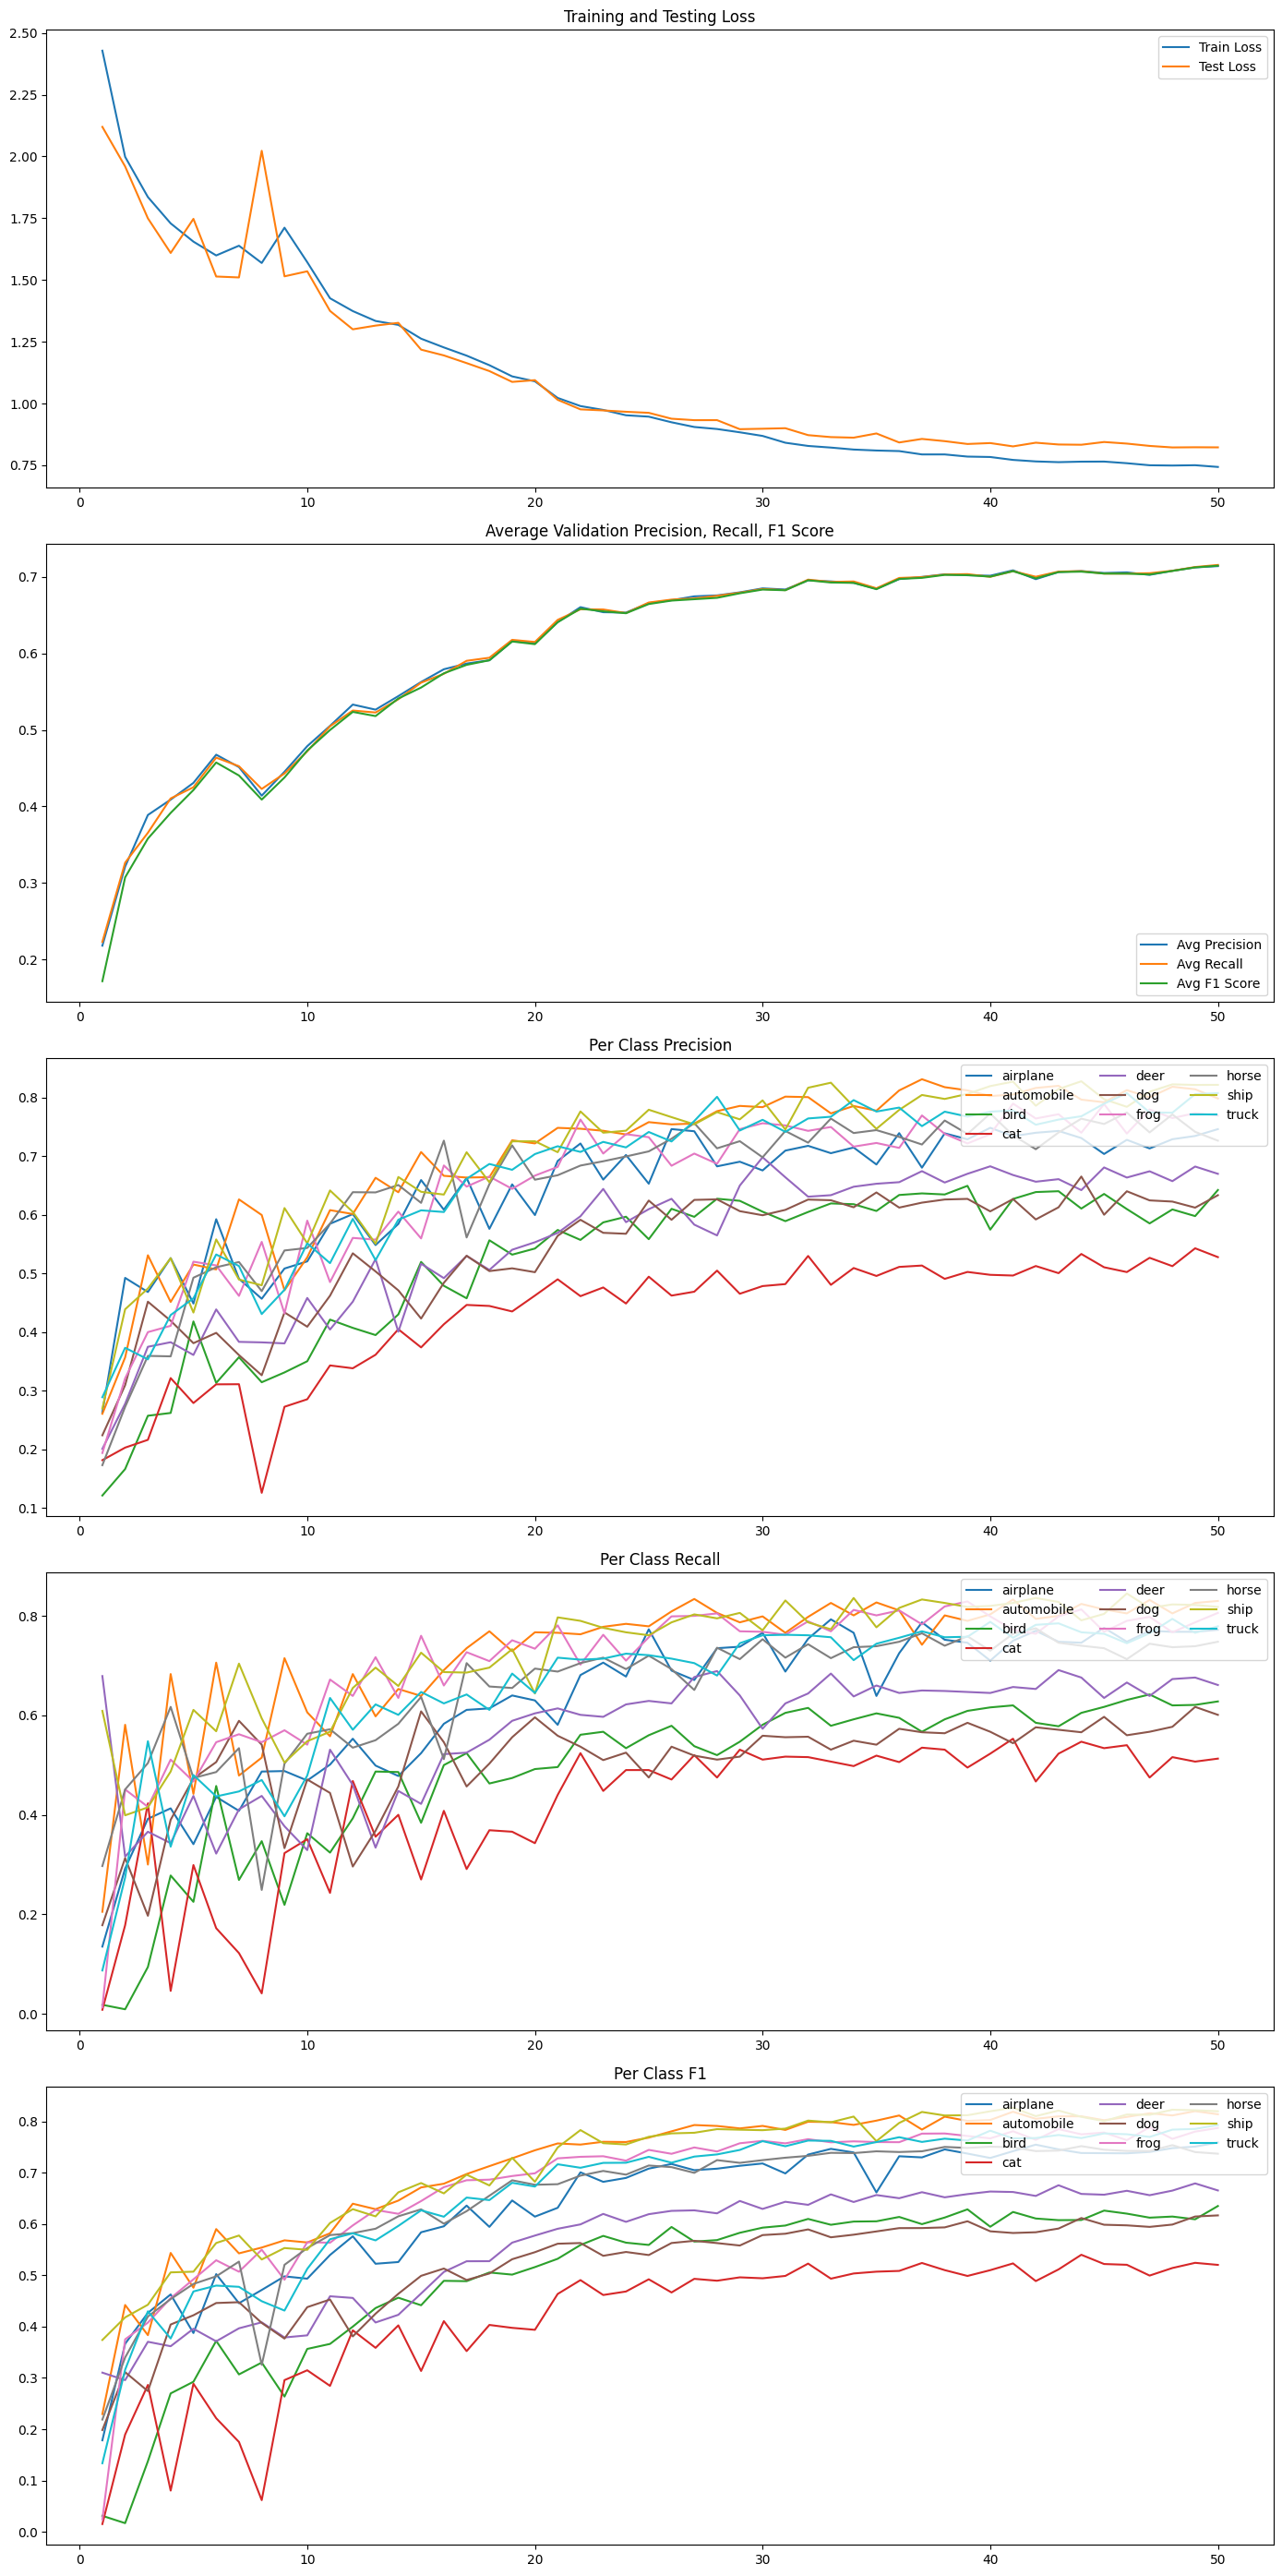

In [83]:
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(14, 28))

plt.subplot(5, 1, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')

plt.subplot(5, 1, 2)
plt.plot(epochs_range, test_precisions, label='Avg Precision')
plt.plot(epochs_range, test_recalls, label='Avg Recall')
plt.plot(epochs_range, test_f1s, label='Avg F1 Score')
plt.legend(loc='lower right')
plt.title('Average Validation Precision, Recall, F1 Score')

plt.subplot(5, 1, 3)
for i in range(10):
    plt.plot(epochs_range, class_precisions[i], label=f'{class_labels[i]}')
plt.legend(loc='upper right', ncol=3)
plt.title(f'Per Class Precision')

plt.subplot(5, 1, 4)
for i in range(10):
    plt.plot(epochs_range, class_recalls[i], label=f'{class_labels[i]}')
plt.legend(loc='upper right', ncol=3)
plt.title(f'Per Class Recall')

plt.subplot(5, 1, 5)
for i in range(10):
    plt.plot(epochs_range, class_f1s[i], label=f'{class_labels[i]}')
plt.legend(loc='upper right', ncol=3)
plt.title(f'Per Class F1')

plt.tight_layout()
plt.show()

In [86]:
for i in range(10):
    print(f'{class_labels[i]}: Precision={class_precisions[i][-1]:.4f}, Recall={class_recalls[i][-1]:.4f}, F1={class_f1s[i][-1]:.4f}')

airplane: Precision=0.7459, Recall=0.7720, F1=0.7587
automobile: Precision=0.7981, Recall=0.8300, F1=0.8137
bird: Precision=0.6421, Recall=0.6280, F1=0.6350
cat: Precision=0.5278, Recall=0.5130, F1=0.5203
deer: Precision=0.6697, Recall=0.6610, F1=0.6653
dog: Precision=0.6333, Recall=0.6010, F1=0.6167
frog: Precision=0.7691, Recall=0.8060, F1=0.7871
horse: Precision=0.7262, Recall=0.7480, F1=0.7369
ship: Precision=0.8213, Recall=0.8180, F1=0.8196
truck: Precision=0.8073, Recall=0.7790, F1=0.7929


In [13]:
def imshow(inputs, title):
    inputs = inputs / 2 + 0.5
    npimg = inputs.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

def test_and_show_examples(model, test_loader):
    model.eval()
    examples = 5
    shown = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            for i in range(inputs.size(0)):
                if shown < examples:
                    img = inputs[i].cpu()
                    real_label = class_labels[labels[i].cpu().item()]
                    predicted_label = class_labels[predicted[i].cpu().item()]
                    
                    imshow(img, f'Predicted: {predicted_label}, Real: {real_label}')
                    shown += 1
                else:
                    return

test_and_show_examples(model, test_loader)

# ДЗ 3

In [39]:
class ContextPredictionTransform:
    def __init__(self, image_size=32, patch_size=6, gap=2):
        self.image_size = image_size
        self.patch_size = patch_size
        self.gap = gap
        
    def extract_patches(self, img):
        img = img.permute(1, 2, 0).numpy()
        patches = []
        
        centers = []
        step = self.patch_size + self.gap
        for i in range(3):
            for j in range(3):
                center = (
                    step * i + self.patch_size // 2,
                    step * j + self.patch_size // 2
                )
                centers.append(center)
        
        jitter = 7
        centers = [(x + random.randint(-jitter, jitter), 
                   y + random.randint(-jitter, jitter)) for x, y in centers]
        
        for center_x, center_y in centers:
            x1 = max(0, center_x - self.patch_size // 2)
            x2 = min(self.image_size, x1 + self.patch_size)
            y1 = max(0, center_y - self.patch_size // 2)
            y2 = min(self.image_size, y1 + self.patch_size)
            
            if x2 - x1 == self.patch_size and y2 - y1 == self.patch_size:
                patch = img[x1:x2, y1:y2]
                patches.append(patch)
        
        return patches, centers

    def color_dropping(self, patch):
        keep_channel = random.randint(0, 2)
        result = np.zeros_like(patch)
        
        for i in range(3):
            if i == keep_channel:
                result[:, :, i] = patch[:, :, i]
            else:
                std = np.std(patch[:, :, keep_channel])
                if std != 0:
                    noise = np.random.normal(0, std/100, patch[:, :, i].shape)
                else:
                    noise = np.random.normal(0, 0.01, patch[:, :, i].shape)
                result[:, :, i] = noise
        
        return result

    def __call__(self, img):
        patches, centers = self.extract_patches(img)
        
        if len(patches) < 9:
            return None, None, None
            
        patches = [self.color_dropping(patch) for patch in patches]
        
        center_idx = 4
        other_idx = random.choice([i for i in range(9) if i != center_idx])
        
        center_pos = centers[center_idx]
        other_pos = centers[other_idx]
        
        dx = other_pos[0] - center_pos[0]
        dy = other_pos[1] - center_pos[1]
        
        if dx < 0 and dy < 0: label = 0
        elif dx == 0 and dy < 0: label = 1
        elif dx > 0 and dy < 0: label = 2
        elif dx < 0 and dy == 0: label = 3
        elif dx > 0 and dy == 0: label = 4
        elif dx < 0 and dy > 0: label = 5
        elif dx == 0 and dy > 0: label = 6
        else: label = 7
        
        center_patch = torch.from_numpy(patches[center_idx]).permute(2, 0, 1).float()
        other_patch = torch.from_numpy(patches[other_idx]).permute(2, 0, 1).float()
        
        return center_patch, other_patch, label

In [79]:
class ContextPredictionModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.features = nn.Sequential(*deepcopy(list(base_model.children())[:-1]))
        self.fc1 = nn.Linear(1280 * 2, 512)
        self.fc2 = nn.Linear(512, 8)
        
    def forward(self, x1, x2):
        feat1 = self.features(x1).flatten(1)
        feat2 = self.features(x2).flatten(1)
        combined = torch.cat([feat1, feat2], dim=1)
        x = F.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

In [71]:
f = nn.Sequential(*deepcopy(list(base_model.children())[:-1]))
t = torch.ones((2,3,32,32))
# t = train_dataset[:2][0].unsqueeze(0)
base_model(t)

tensor([[ 3.4276,  3.7326, -3.1208,  0.5713,  5.1348,  2.7656,  5.9192,  5.1246,
          1.4295,  5.5943],
        [-4.5541,  3.6286,  1.8194,  2.3857, -1.6354, -4.6588, -5.8029, -0.9522,
          0.9355, -0.7754]], grad_fn=<AddmmBackward0>)

In [60]:
from PIL import Image
image = Image.open('/kavesnin/denis_photo.jpg')

In [80]:
def pretrain_model(base_model, train_dataset, num_epochs=10):
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    
    ssl_model = ContextPredictionModel(base_model).to(device)
    ssl_transform = ContextPredictionTransform()
    optimizer = optim.Adam(ssl_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    wandb.init(
        project='Homework-1',
        name='ssl_pretraining',
    )
    
    for epoch in range(num_epochs):
        ssl_model.train()
        running_loss = 0.0
        for imgs, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            imgs = imgs.to(device)
            batch_size = imgs.size(0)
            
            center_patches = []
            other_patches = []
            labels = []
            
            for img in imgs:
                center_patch, other_patch, label = ssl_transform(img.cpu())
                if center_patch is not None:
                    center_patches.append(center_patch)
                    other_patches.append(other_patch)
                    labels.append(label)
            
            if len(center_patches) == 0:
                continue
                
            center_patches = torch.stack(center_patches).to(device)
            other_patches = torch.stack(other_patches).to(device)
            labels = torch.tensor(labels).to(device)
            
            outputs = ssl_model(center_patches, other_patches)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        
        ssl_model.eval()
        val_loss = 0.0
        val_batches = 0
        with torch.no_grad():
            for imgs, _ in val_loader:
                imgs = imgs.to(device)
                
                center_patches = []
                other_patches = []
                labels = []
                
                for img in imgs:
                    center_patch, other_patch, label = ssl_transform(img.cpu())
                    if center_patch is not None:
                        center_patches.append(center_patch)
                        other_patches.append(other_patch)
                        labels.append(label)
                
                if len(center_patches) == 0:
                    continue
                    
                center_patches = torch.stack(center_patches).to(device)
                other_patches = torch.stack(other_patches).to(device)
                labels = torch.tensor(labels).to(device)
                
                outputs = ssl_model(center_patches, other_patches)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_batches += 1
        
        if val_batches > 0:
            val_loss = val_loss / val_batches
            
        ssl_model.train()
        
        wandb.log({
            'epoch': epoch + 1,
            'ssl_train_loss': train_loss,
            'ssl_val_loss': val_loss
        })
            
    wandb.finish()
    return ssl_model.features

In [81]:
def create_reduced_dataset(dataset, percent):
    n = len(dataset)
    indices = list(range(n))
    np.random.shuffle(indices)
    
    n_samples = int(n * percent / 100)
    selected_indices = indices[:n_samples]
    
    return torch.utils.data.Subset(dataset, selected_indices)

In [104]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler, running_name, num_epochs=50):
    wandb.init(
        project='Homework-1',
        name=running_name,
    )
    for i, epoch in enumerate(range(num_epochs)):
        train_loss = train(model, train_loader, criterion, optimizer)
        test_loss, precision, recall, f1, precision_class, recall_class, f1_class = test(model, test_loader, criterion)

        scheduler.step()
    
        log_data = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'precision_avg': precision,
            'recall_avg': recall,
            'f1_avg': f1,
        }
        
        for class_idx, value in enumerate(precision_class):
            log_data[f'Precision/{class_labels[class_idx]}'] = value
        
        for class_idx, value in enumerate(recall_class):
            log_data[f'Recall/{class_labels[class_idx]}'] = value
        
        for class_idx, value in enumerate(f1_class):
            log_data[f'F1/{class_labels[class_idx]}'] = value
        
        wandb.log(log_data)
    wandb.finish()

In [83]:
base_model = create_model('efficientnet_b0', pretrained=False, num_classes=10)
pretrained_features = pretrain_model(base_model, train_dataset)

Epoch 1/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/704 [00:00<?, ?it/s]

epoch,▁▂▃▃▄▅▆▆▇█
ssl_train_loss,█▅▃▃▂▂▄▂▂▁
ssl_val_loss,█▄▂▂▃▃▁▂▁▂
epoch,10
ssl_train_loss,1.47038
ssl_val_loss,1.48159


In [105]:
def run_experiments():
    percentages = [100, 50, 10]
    results = {}
    
    for percent in percentages:
        print(f"\nExperiment with {percent}% of labeled data")
        
        reduced_train_dataset = create_reduced_dataset(train_dataset, percent)
        reduced_train_loader = DataLoader(reduced_train_dataset, batch_size=64, shuffle=True)
        
        model_scratch = create_model('efficientnet_b0', pretrained=False, num_classes=10).to(device)
        optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
        scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size=10, gamma=0.4)
        
        train_metrics_scratch = train_and_evaluate(
            model_scratch, reduced_train_loader, test_loader,
            optimizer_scratch, scheduler_scratch, f'scratch_{percent}', num_epochs=50
        )
        
        model_ssl = create_model('efficientnet_b0', pretrained=False, num_classes=10).to(device)
        features = deepcopy(pretrained_features)
        model_ssl.conv_stem = features[0]
        model_ssl.bn1 = features[1]
        model_ssl.blocks = features[2]
        model_ssl.conv_head = features[3]
        model_ssl.bn2 = features[4]
        model_ssl.global_pool = features[5]
        
        optimizer_ssl = optim.Adam(model_ssl.parameters(), lr=0.001)
        scheduler_ssl = lr_scheduler.StepLR(optimizer_ssl, step_size=10, gamma=0.4)
        
        train_metrics_ssl = train_and_evaluate(
            model_ssl, reduced_train_loader, test_loader,
            optimizer_ssl, scheduler_ssl, f'ssl_{percent}', num_epochs=50
        )
        
        results[percent] = {
            'scratch': train_metrics_scratch,
            'ssl': train_metrics_ssl
        }
            
    return results

In [106]:
criterion = nn.CrossEntropyLoss()

results = run_experiments()


Experiment with 100% of labeled data


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

F1/airplane,▁▃▅▅▄▆▅▅▆▇▇▆▇▇▇▇▇████▇██████████████████
F1/automobile,▁▃▃▄▃▅▅▄▆▆▆▆▆▇▆▇▇▇█▇▇▇█▇▇███████████████
F1/bird,▂▂▁▃▂▃▄▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇████████████
F1/cat,▃▂▄▅▁▆▅▅▆▆▆▆▇▆▆▇▇▇▇▇███████████████████▇
F1/deer,▁▅▅▃▄▅▄▅▆▆▆▆▇▇▆▇▇▇▇▇███▇████████████████
F1/dog,▁▃▅▂▄▅▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
F1/frog,▁▄▄▅▄▅▆▅▆▇▇▇▇▇▇▇▇▇██▇███████████████████
F1/horse,▁▃▃▄▃▅▅▄▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇████████████████
F1/ship,▁▂▁▃▂▄▄▄▅▆▆▆▇▇▆▇▇▇▇▇█▇▇▇██████▇█████████
F1/truck,▁▁▃▄▂▄▁▃▄▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇███████▇████████
Precision/airplane,▁▂▄▄▂▅▅▄▄▆▆▇▆▇▆█▇▇▇▇▇▇▇▇█▇▇█▇██▇▇███▇█▇█


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

F1/airplane,▁▂▄▄▅▅▅▄▆▆▇▇▇▇▇▆▇▇▇▇▇█▇▇▇██▇▇██████▇█▇██
F1/automobile,▁▂▄▃▄▄▄▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇█▇█▇████████▇▇████
F1/bird,▁▃▄▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇█▇███████████████████
F1/cat,▁▁▆▃▆▆▆▅▆▆▇▇▇▇▇▇█▇▇█████████████████████
F1/deer,▁▁▄▂▄▂▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇██▇███████▇████
F1/dog,▁▃▂▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▆█▇▇▇▇▇▇▇▇
F1/frog,▁▃▃▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇███████████████████
F1/horse,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇█▇▇██▇██████████████████
F1/ship,▁▂▃▂▄▃▄▄▆▅▆▆▇▆▆▇▆▇▇▇▇▇█▇▇▇▇▇█▇███▇▇█████
F1/truck,▁▃▃▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████████▇████████
Precision/airplane,▁▄▄▄▅▄▅▅▆▆▇▆▇▆▇▆▇▇▆▇▇▇█▇▇▇▇▇█▇█▇█▇█▇▇█▇█



Experiment with 50% of labeled data


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

F1/airplane,▁▄▁▃▅▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████
F1/automobile,▁▁▂▄▄▅▅▃▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
F1/bird,▂▂▁▁▂▄▅▄▆▅▆▅▆▆▆▆▆▇▇▇▆▇▇▇█▇███▇██████████
F1/cat,▁▅▃▃▄▂▄▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇█▇▇█▇▇▇▇███▇████
F1/deer,▃▂▂▃▄▃▁▂▃▄▄▅▅▅▅▄▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇█▇███████
F1/dog,▄▁▅▆▅▆▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇███▇███████████▇█
F1/frog,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██▇███████▇█████████
F1/horse,▁▁▃▃▄▄▅▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇██▇███████████████
F1/ship,▃▁▄▄▄▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██████████████
F1/truck,▁▂▃▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇█▇███████████
Precision/airplane,▁▃▂▅▆▅▄▅▇▆▇▆▆▅▇▅▆▇▇▇▇▇▇▇▇▇█▇██▇▇▇███▇▇██


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

F1/airplane,▂▅▂▄▅▁▅▅▆▆▆▆▆▅▆▇▇▇▇▇▇▇▇▇████████████████
F1/automobile,▁▅▅▄▇▆▇▆▆▇▇▆▇▇▇▇█▇▇███▇█████████████████
F1/bird,▁▂▄▁▂▃▁▄▄▅▅▆▅▆▇▆▇▇▇▇▇▇▇▇▇▇████████▇█████
F1/cat,▃▄▆▁▅▁▆▅▆▇▇▆▇▆▇▇▇█▇▇█▇█▇██▇█████████████
F1/deer,▅▄▁▂▅▅▆▅▆▅▅▆▇▆▅▇▇▇▇▇▇▇▇▇▇▇▇▇███▇████████
F1/dog,▅▅▁▄▅▅▁▆▇▇▇▇▇▇▇▆▇▇▇█▇▇██▇███████▇███▇███
F1/frog,▁▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇██▇█████████████████████
F1/horse,▁▂▃▂▄▁▅▃▅▆▆▆▆▇▇▇▇▇▇▇█▇▇█▇██▇█▇██████████
F1/ship,▃▁▃▁▄▄▄▄▅▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇████████████
F1/truck,▄▄▅▁▄▄▄▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████▇████
Precision/airplane,▇▃▄▁▄▂▃▂▄▆▅▅▇▇▆▆▇▆▆▇▇▇█▇▇▇▇█████▇▇███▇██



Experiment with 10% of labeled data


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

F1/airplane,▂▂▁▄▆▇▃█▆▆▅▅▄▅▅▅▇█▆▆▆▇▇▇████▇▇▇▇▇▇▆▇▇█▇▇
F1/automobile,▂▂▃▁▃▂▃▁▃▄▄▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█
F1/bird,▃▄▁▁█▇▃▃▃▄▅▃▄▂▂▃▂▂▃▅▃▃▃▅▄▅▅▃▄▅▄▄▅▃▆▄▅▆▄▄
F1/cat,▁▁▁▂▄▃▆▁▆▆▇▃▆▇▄▇▇▇▇▇▆▇▇█▇█▇████▇▇██▇████
F1/deer,▇▁▁▁▆▁▁▁▃▁▇▂▁▅▁▇▄▂▄▆▇▃▄▆▆▆▆█▄▄▆▄▇▃▅▂▆▄▅▅
F1/dog,▁▅▃▁▃▅▃▇▄▂▃▇▃▄▇▄▇▅▆▅█▆▇▆▆▆▆▅▇█▇▆▇▆▇▆▇▇█▇
F1/frog,▁▂▃▂▅▅▅▅▅▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇█▇▇▇▇▇
F1/horse,▂▁▅▃▄▅▆▄▄▆▆▅▆▆▆▆▆▆▇▇▇▇▆▆▇▇█▇▇█▇██▇█▇▇▇██
F1/ship,▁▃▄▄▃▂▆▃▅▆▇▇▆▇▇▆▆▇▇▇▇▇▇▇█▆█▇██▇▇█████▇▇█
F1/truck,▃▁▄▅▆▆▆▆▆▅▆▅▆▇▆▆▇▇▇▇▇██▇█▇▇▇████████████
Precision/airplane,▃▄▁▅▅▅▅▅▇▆▅▆▅▆▆▇▇▇▇▇▇▇▇▆▇▇█▇▇▇▇█▇▇▇▇▇▇██


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

F1/airplane,▄▄▁▆▄▄▄▇▆▇▆▆█▇█▆▇▇██▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
F1/automobile,▁▄▄▁▁▂▅▃▇▄▇▆▂▄▆▅▇▇█▇▇█▇▇▇█▇▇▇█▇█▇▇▇█▇▇█▇
F1/bird,▃▄▁▇▃▂▄▅▃▄▁▄▁▃▁▁▁▁▂▂▂▂▄▆█▄▅▅▆▄▇▆▅▄▅▅▇▇▅█
F1/cat,▁▁▂▆▇▅▆▂▅▃▃▄▆▆▅▆▇▇▆▇▇▆▆▇▇▇██▇█▇█▇█▇▇████
F1/deer,▄▁▁██▇▁▄▃▄▇▆▅▅▇█▅▆▇▄▅▆▇▆▇▆▇▅▇▆▆▇▇▇▇▆▇▇▇▆
F1/dog,▅▅▆▅▁▁▁▇▅▇▇▇▆▆█▆▆▇██▇██▆██▆▇▇█▇▇███████▇
F1/frog,▁▆▅▁▁▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇█████████████████
F1/horse,▃▁▃▁▂▅▁▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█▇█▇▇████████████
F1/ship,▃▄▆▁▅▆▇▄▇▆▆▇▆▇▆▇▇▇▇▇▇▇██▇▇████▇█████████
F1/truck,▄▁▂▅▆▆▅▇▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇████▇████
Precision/airplane,▄▄▁▆▅▆▅▅▇▆▆█▇▇▇█▇▇▇▇▇███▇▇▇▇████████▇▇█▇
